# Sin wave prediction

In [1]:
import torch
from torch import nn
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
DEVICE

device(type='cuda')

In [2]:
class LSTMRegressor(nn.Module):
    
    def __init__(self, hidden_size: int, LSTM_layers: int, dropout: float= 0.,
                 learning_rate: float= 0.001):
        super().__init__()
        
        self.lstm = nn.LSTM(input_size=1, hidden_size=hidden_size, proj_size=0, num_layers=LSTM_layers, dropout=dropout, batch_first=True).to(DEVICE)
        
        layers = []
        if dropout > 0:
            layers += [nn.Dropout(dropout)]
        layers += [nn.Linear(hidden_size, 1)]
        self.top_layers = nn.Sequential(*layers).to(DEVICE)
        
        self.loss_func = nn.MSELoss()
        self.optimizer = torch.optim.Adam(self.parameters(), lr=learning_rate)
        
        self.eval()
    
    def forward(self, X, future = 1):
        X = X.to(DEVICE)

        lstm_out, states = self.lstm(X)
        output = self.top_layers(lstm_out)
        
        outputs = [output]
        output = output[..., -1:, :]
        for _ in range(future-1):
            lstm_out, states = self.lstm(output, states)
            output = self.top_layers(lstm_out)
            outputs.append(output)
        
        outputs = torch.cat(outputs, dim=-2)            
        return outputs
    
    def calculate_loss(self, X, Y):
        X, Y = X.to(DEVICE), Y.to(DEVICE)
        
        preds = self(X)
        loss = self.loss_func(preds, Y)
        return loss
    
    def optimize(self, X, Y):
        loss = self.calculate_loss(X, Y)
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
        
        return loss
    
model = LSTMRegressor(hidden_size=50, LSTM_layers=2, learning_rate= 0.003)
print(f'Model Parameters- {sum(p.numel() for p in model.parameters())}')
model

Model Parameters- 31051


LSTMRegressor(
  (lstm): LSTM(1, 50, num_layers=2, batch_first=True)
  (top_layers): Sequential(
    (0): Linear(in_features=50, out_features=1, bias=True)
  )
  (loss_func): MSELoss()
)

In [3]:
N = 100

def func(start):
    return np.sin(np.arange(start, 50+start, 0.1)).astype(np.float32)

(100, 500, 1)

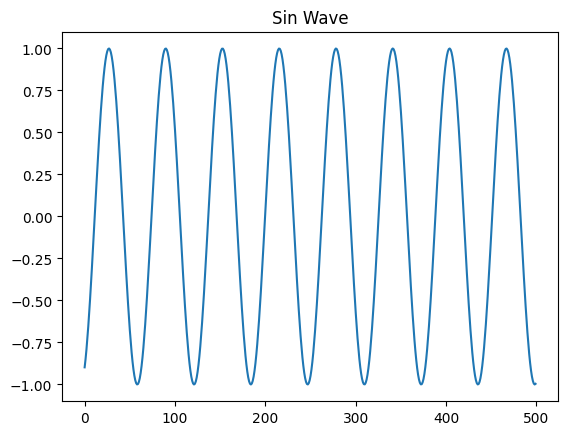

In [4]:
dataset = np.empty((0, 500, 1), np.float32)
for i in range(N):
    dataset = np.append(dataset, func(np.random.randint(100)).reshape((1, -1, 1)), axis=0)

plt.plot(dataset[0])
plt.title("Sin Wave")
dataset.shape

In [5]:
def train(model, dataset, epochs):
    model.train()
    for e in range(epochs):
        X = torch.from_numpy(dataset[:, :-1])
        Y = torch.from_numpy(dataset[:, 1:])
        loss = model.optimize(X, Y).cpu().detach()
        if (e+1)%100 == 0:  
            print(f"Epoch {e+1} loss: {loss}")
    model.eval()
    
train(model, dataset[:95], 500)

Epoch 100 loss: 0.0013694301014766097
Epoch 200 loss: 0.0009033055393956602
Epoch 300 loss: 0.000726254191249609
Epoch 400 loss: 0.0006120617617852986
Epoch 500 loss: 0.0005091766943223774


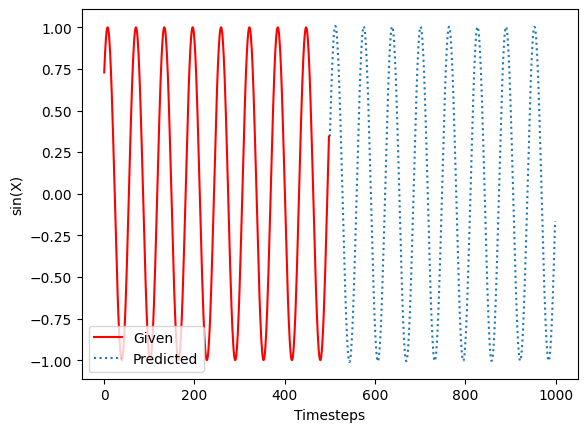

In [7]:
i = 95 + 3
future=500

X = dataset[i][:-1]
Y = dataset[i][1:]

preds = model(torch.tensor(X), future=future).cpu().detach()
plt.plot(Y, 'r', label="Given")
plt.plot(range(500, 500+future), preds[-future:], ':', label="Predicted")
plt.ylabel("sin(X)")
plt.xlabel("Timesteps")
plt.legend(loc='lower left')